In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys
import celerite
from celerite import terms
import scipy.optimize as op
import emcee
import corner
from tqdm import tqdm, tqdm_notebook

In [2]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

In [3]:
class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_c", "log_P")
 
    def get_real_coefficients(self, params):
        log_a, log_c, log_P = params
        
        return (
            np.exp(log_a) * 0.5, np.exp(log_c),
        )
 
    def get_complex_coefficients(self, params):
        log_a, log_c, log_P = params
        
        return (
            np.exp(log_a) / (2.0), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

In [4]:
def read_data(input_dir, filename1):
        
    infile = input_dir + "/" + filename1 
    nu,lam_squared,stokesQ,stokesU = np.loadtxt(infile,delimiter=' ',usecols=(0,1,2,3),unpack=True)   
    
    return nu, lam_squared, stokesQ, stokesU

In [5]:
log_a = 0.1; log_c = 0.1; log_P = 1.0 

k1 = CustomTerm(log_a, log_c, log_P)  
k2 = terms.JitterTerm(log_sigma = -2.)
kernel = k1+k2
gp = celerite.GP(kernel, mean=0.0, fit_mean=False)

In [6]:
indir = "./rfi_flagged/minus40-thin"
nu, l2, stokesQ, stokesU = read_data(indir, "training.txt")

In [7]:
gp.compute(l2[::-1])

In [8]:
noise = 1.0
stokesQ+=np.random.normal(loc =0.0, scale=noise, size = len(stokesQ))
stokesU+=np.random.normal(loc =0.0, scale=noise, size = len(stokesU))

In [9]:
t1 = np.linspace(np.min(l2), np.max(l2), 512)

In [10]:
# set the loglikelihood:
def lnlike(p, x, y1, y2):
 
    ln_a = p[0]
    ln_c = p[1]      
    ln_p = p[2]  
    ln_s = p[3]

    p0 = np.array([ln_a,ln_c,ln_p,ln_s])
 
    # update kernel parameters:
    gp.set_parameter_vector(p0)
 
    # calculate the likelihood:
    ll1 = gp.log_likelihood(y1)
    ll2 = gp.log_likelihood(y2)
    ll = ll1 + ll2
    
    return ll if np.isfinite(ll) else 1e25

In [11]:
# set the logprior
def lnprior(p):
 
    lna = p[0]
    lnc = p[1]
    lnP = p[2]
    lns = p[3]
 
    if (-10.<lna<5.) and (-10.<lnc<5.) and (-10<lnP<5.) and (-6<lns<2.):    
        return 0.0
 
    return -np.inf

In [12]:
# set the logposterior:
def lnprob(p, x, y1, y2):
 
    lp = lnprior(p)
 
    return lp + lnlike(p, x, y1, y2) if np.isfinite(lp) else -np.inf

In [13]:
data = (l2[::-1],stokesQ[::-1],stokesU[::-1])

In [14]:
p = gp.get_parameter_vector()

initial = np.zeros(len(p))
print("Initial guesses: ",initial)
 
# initial log(likelihood):
init_logL = gp.log_likelihood(stokesQ[::-1]) + gp.log_likelihood(stokesU[::-1])
 
# set the dimension of the prior volume
# (i.e. how many parameters do you have?)
ndim = len(initial)
print("Number of parameters: ",ndim)
 
nwalkers = 32
 
p0 = [np.array(initial) + 1e-5 * np.random.randn(ndim)
      for i in range(nwalkers)]

# initalise the sampler:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

Initial guesses:  [0. 0. 0. 0.]
Number of parameters:  4


In [15]:
# run a few samples as a burn-in:
print("Running burn-in")
p0, lnp, _ = sampler.run_mcmc(p0, 500)
sampler.reset()
 
print("Finished burn-in")

Running burn-in
Finished burn-in


In [16]:
# take the highest likelihood point from the burn-in as a
# starting point and now begin your production run:
print("Running production")
p = p0[np.argmax(lnp)]
p0 = [p + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]
p0, lnp, _ = sampler.run_mcmc(p0, 5000)
 
print("Finished Production")

Running production
Finished Production


In [17]:
# Find the maximum likelihood values:
ml = p0[np.argmax(lnp)]
print("Maximum likelihood parameters: ",np.exp(ml))
print("Period: ",np.pi/np.exp(ml[2])," rad/m^2")

Maximum likelihood parameters:  [1.196821   0.43551885 0.06311591 0.99095479]
Period:  49.77497070000069  rad/m^2


In [18]:
p = np.array(ml)
gp.set_parameter_vector(p)
ml_logL = gp.log_likelihood(stokesQ[::-1]) + gp.log_likelihood(stokesU[::-1])
print("ML logL:", ml_logL)

ML logL: -1956.7019398306988


In [19]:
gp.set_parameter_vector(p)

mu_q, cov_q = gp.predict(stokesQ[::-1], t1) #return_cov=False)
std_q = np.sqrt(np.diag(cov_q))

mu_u, cov_u = gp.predict(stokesU[::-1], t1) #return_cov=False)
std_u = np.sqrt(np.diag(cov_u))

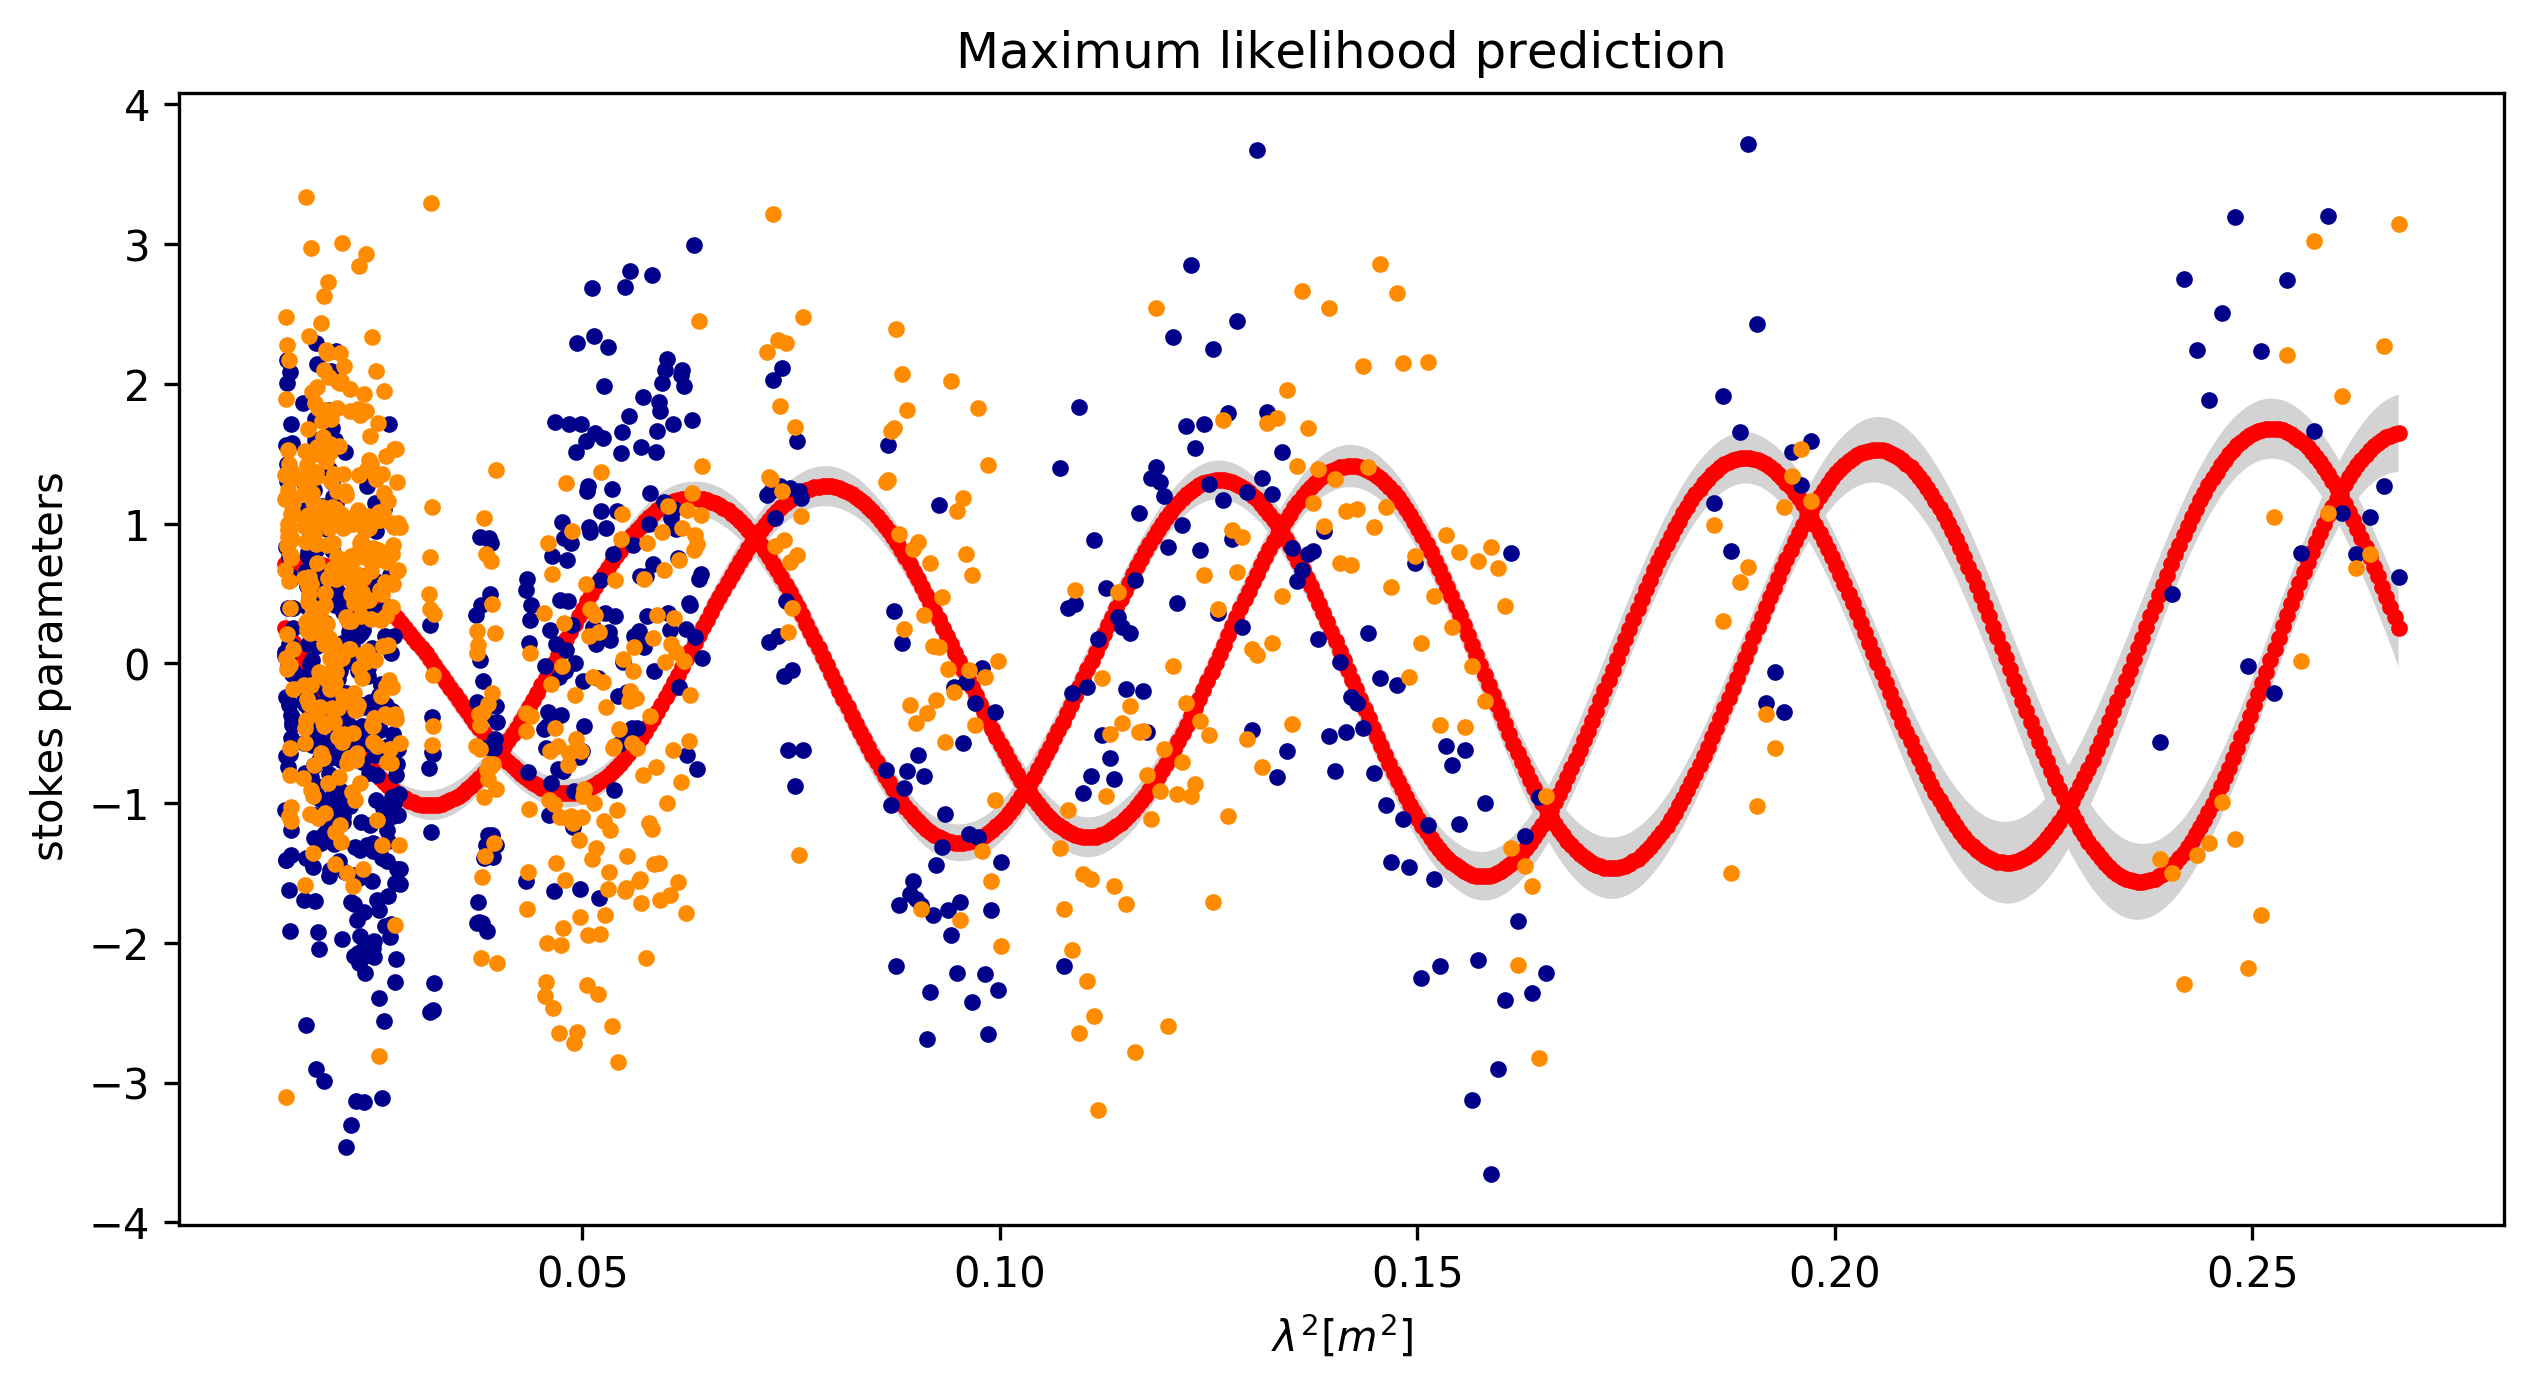

In [20]:
ax = pl.subplot(111)

pl.plot(t1,mu_q, linestyle='none', marker='.', color = 'red')
pl.plot(t1,mu_u, linestyle='none', marker='.', color = 'red')

pl.plot(l2[::-1],stokesQ[::-1], linestyle='none', marker='.', color = 'darkblue')
pl.plot(l2[::-1],stokesU[::-1], linestyle='none', marker='.', color = 'darkorange')

ax.fill_between(t1,mu_q-std_q,mu_q+std_q, facecolor='lightgray')
ax.fill_between(t1,mu_u-std_u,mu_u+std_u, facecolor='lightgray')

pl. title('Maximum likelihood prediction')
pl.ylabel('stokes parameters ')
pl.xlabel('$\lambda^2 [m^2]$')

pl.show()

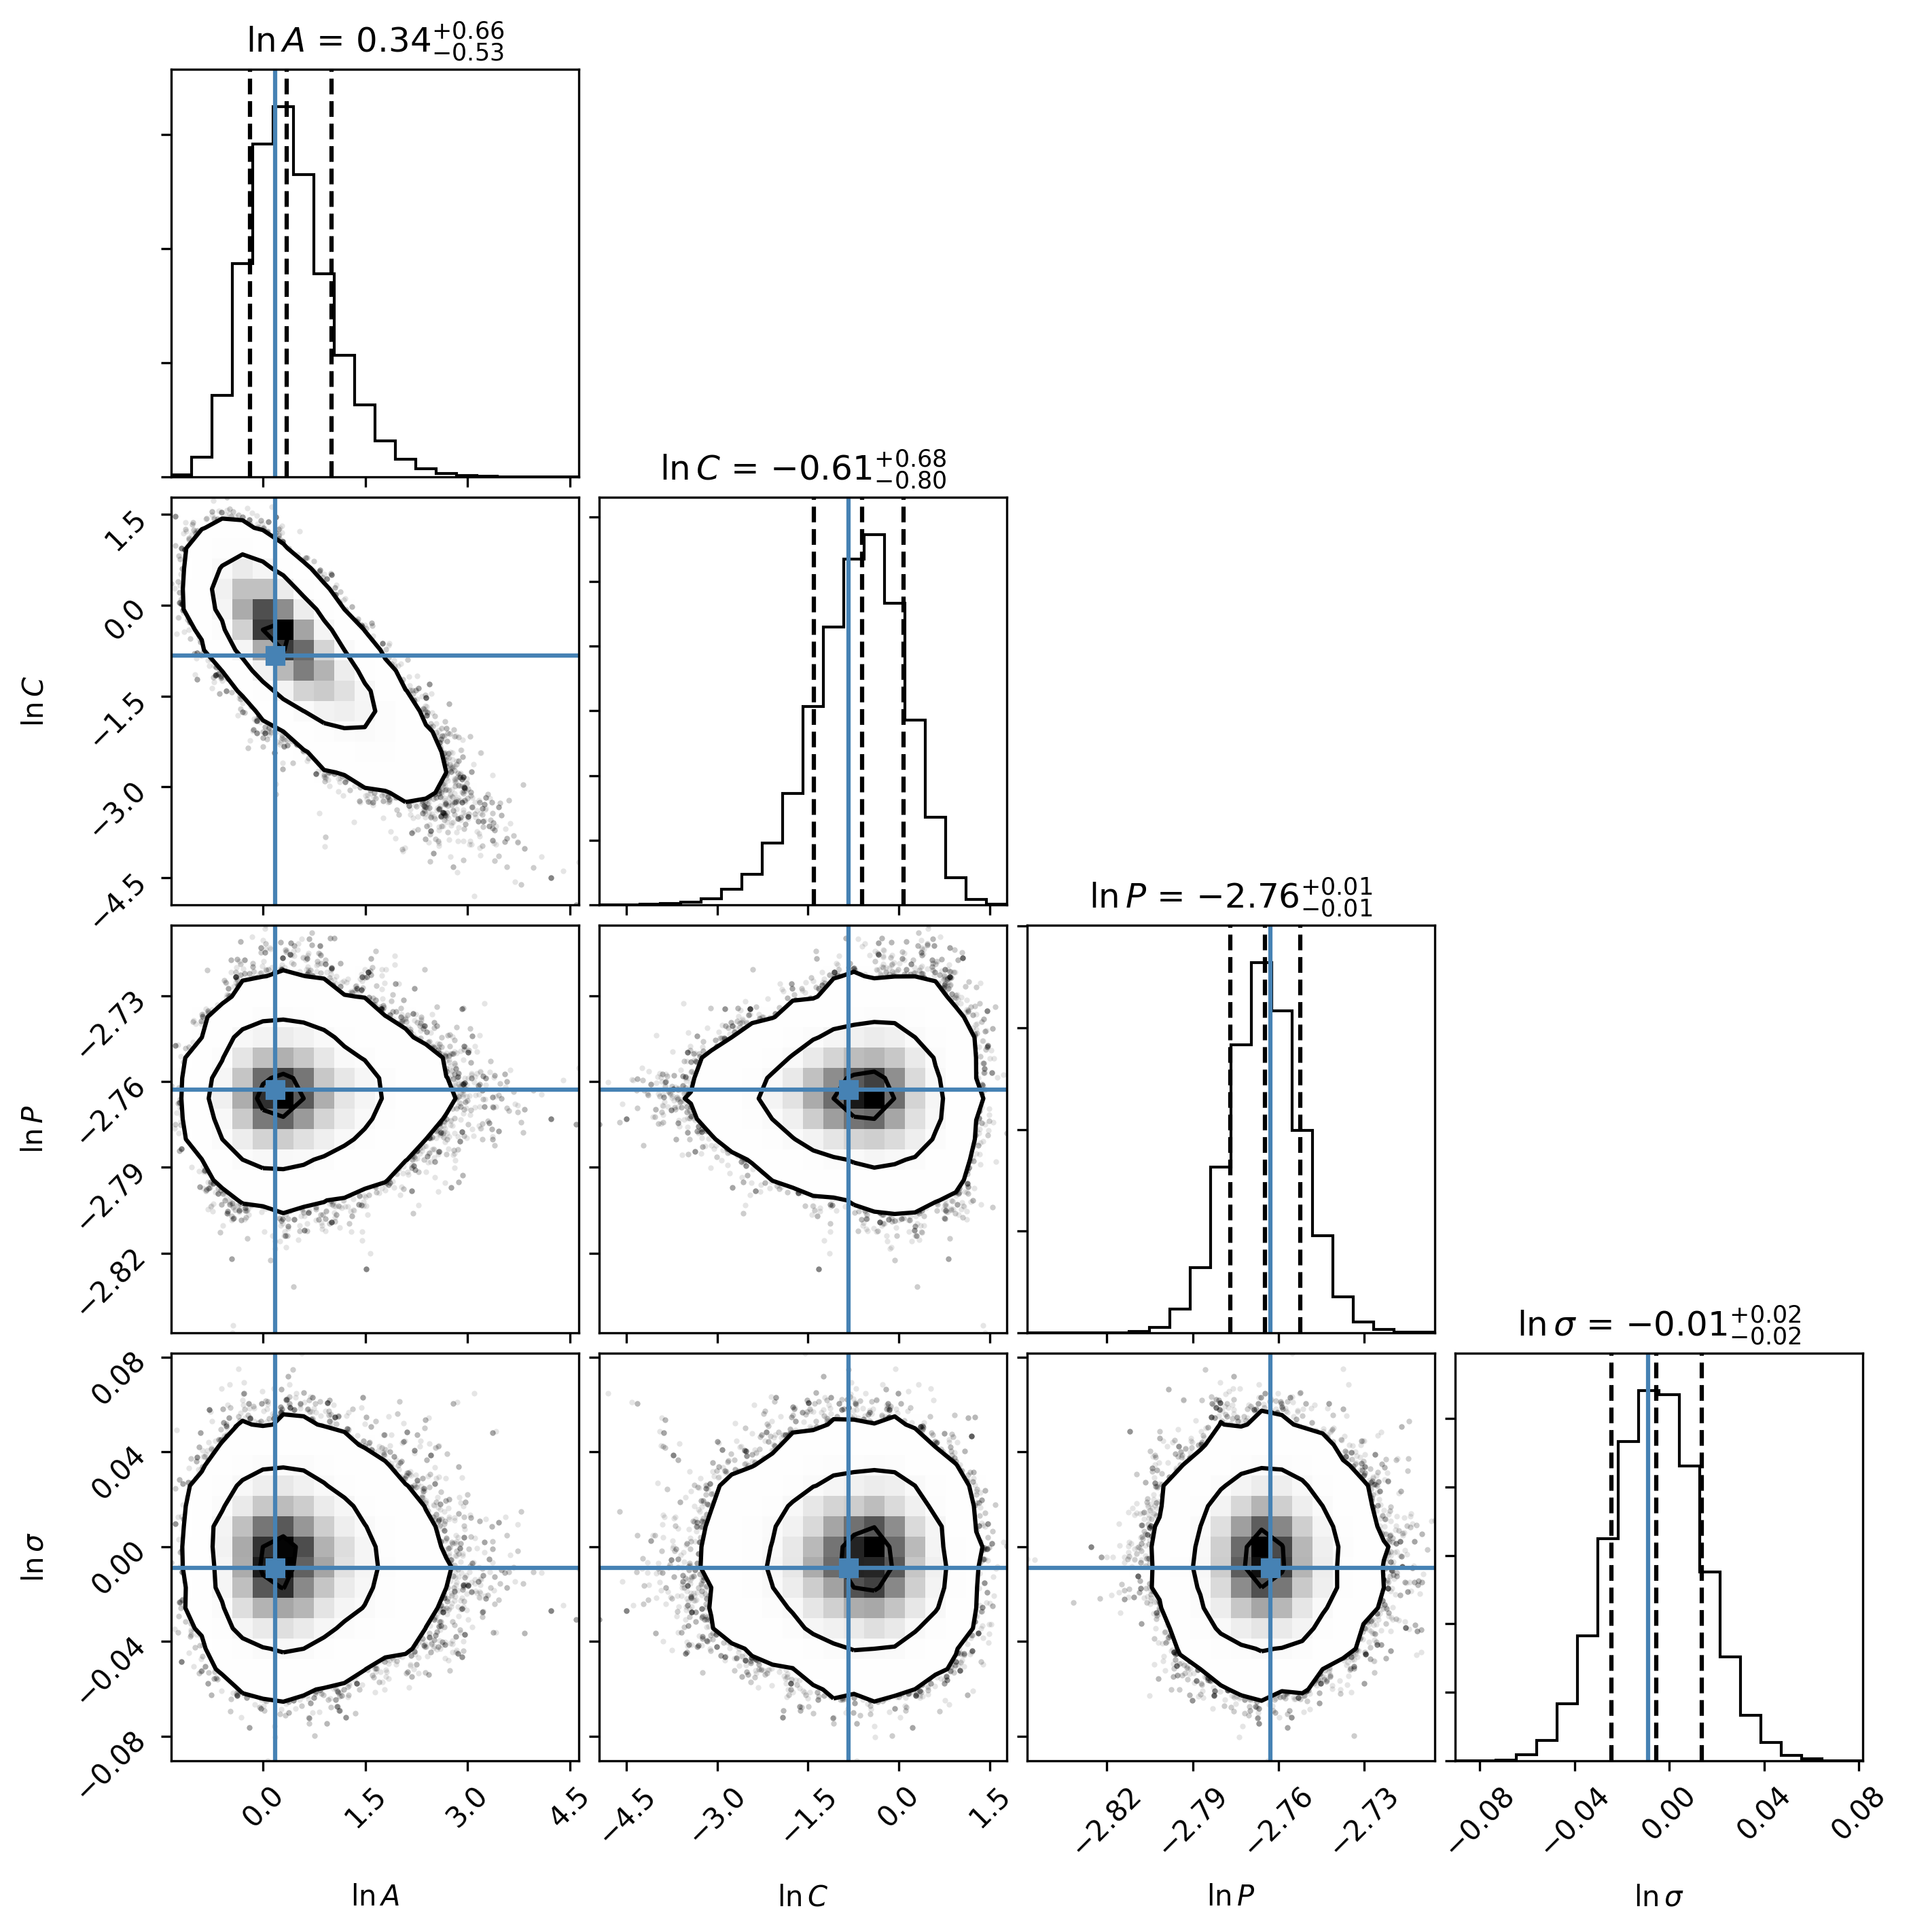

In [21]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
#samples = sampler.flatchain

figure = corner.corner(samples, labels=[r"$\ln\,A$", r"$\ln\,C$", r"$\ln\,P$", r"$\ln\,\sigma$"],
                         truths=ml,
                         quantiles=[0.16,0.5,0.84],
                         levels=[0.19,0.86,0.99],
                         title="Faraday Thin",
                         show_titles=True, title_args={"fontsize": 10})

In [22]:
mu_q, cov_q = gp.predict(stokesQ[::-1], l2[::-1]) #return_cov=False)
std_q = np.sqrt(np.diag(cov_q))

mu_u, cov_u = gp.predict(stokesU[::-1], l2[::-1]) #return_cov=False)
std_u = np.sqrt(np.diag(cov_u))

In [23]:
diff_q = (stokesQ[::-1] - mu_q)/noise
diff_u = (stokesU[::-1] - mu_u)/noise

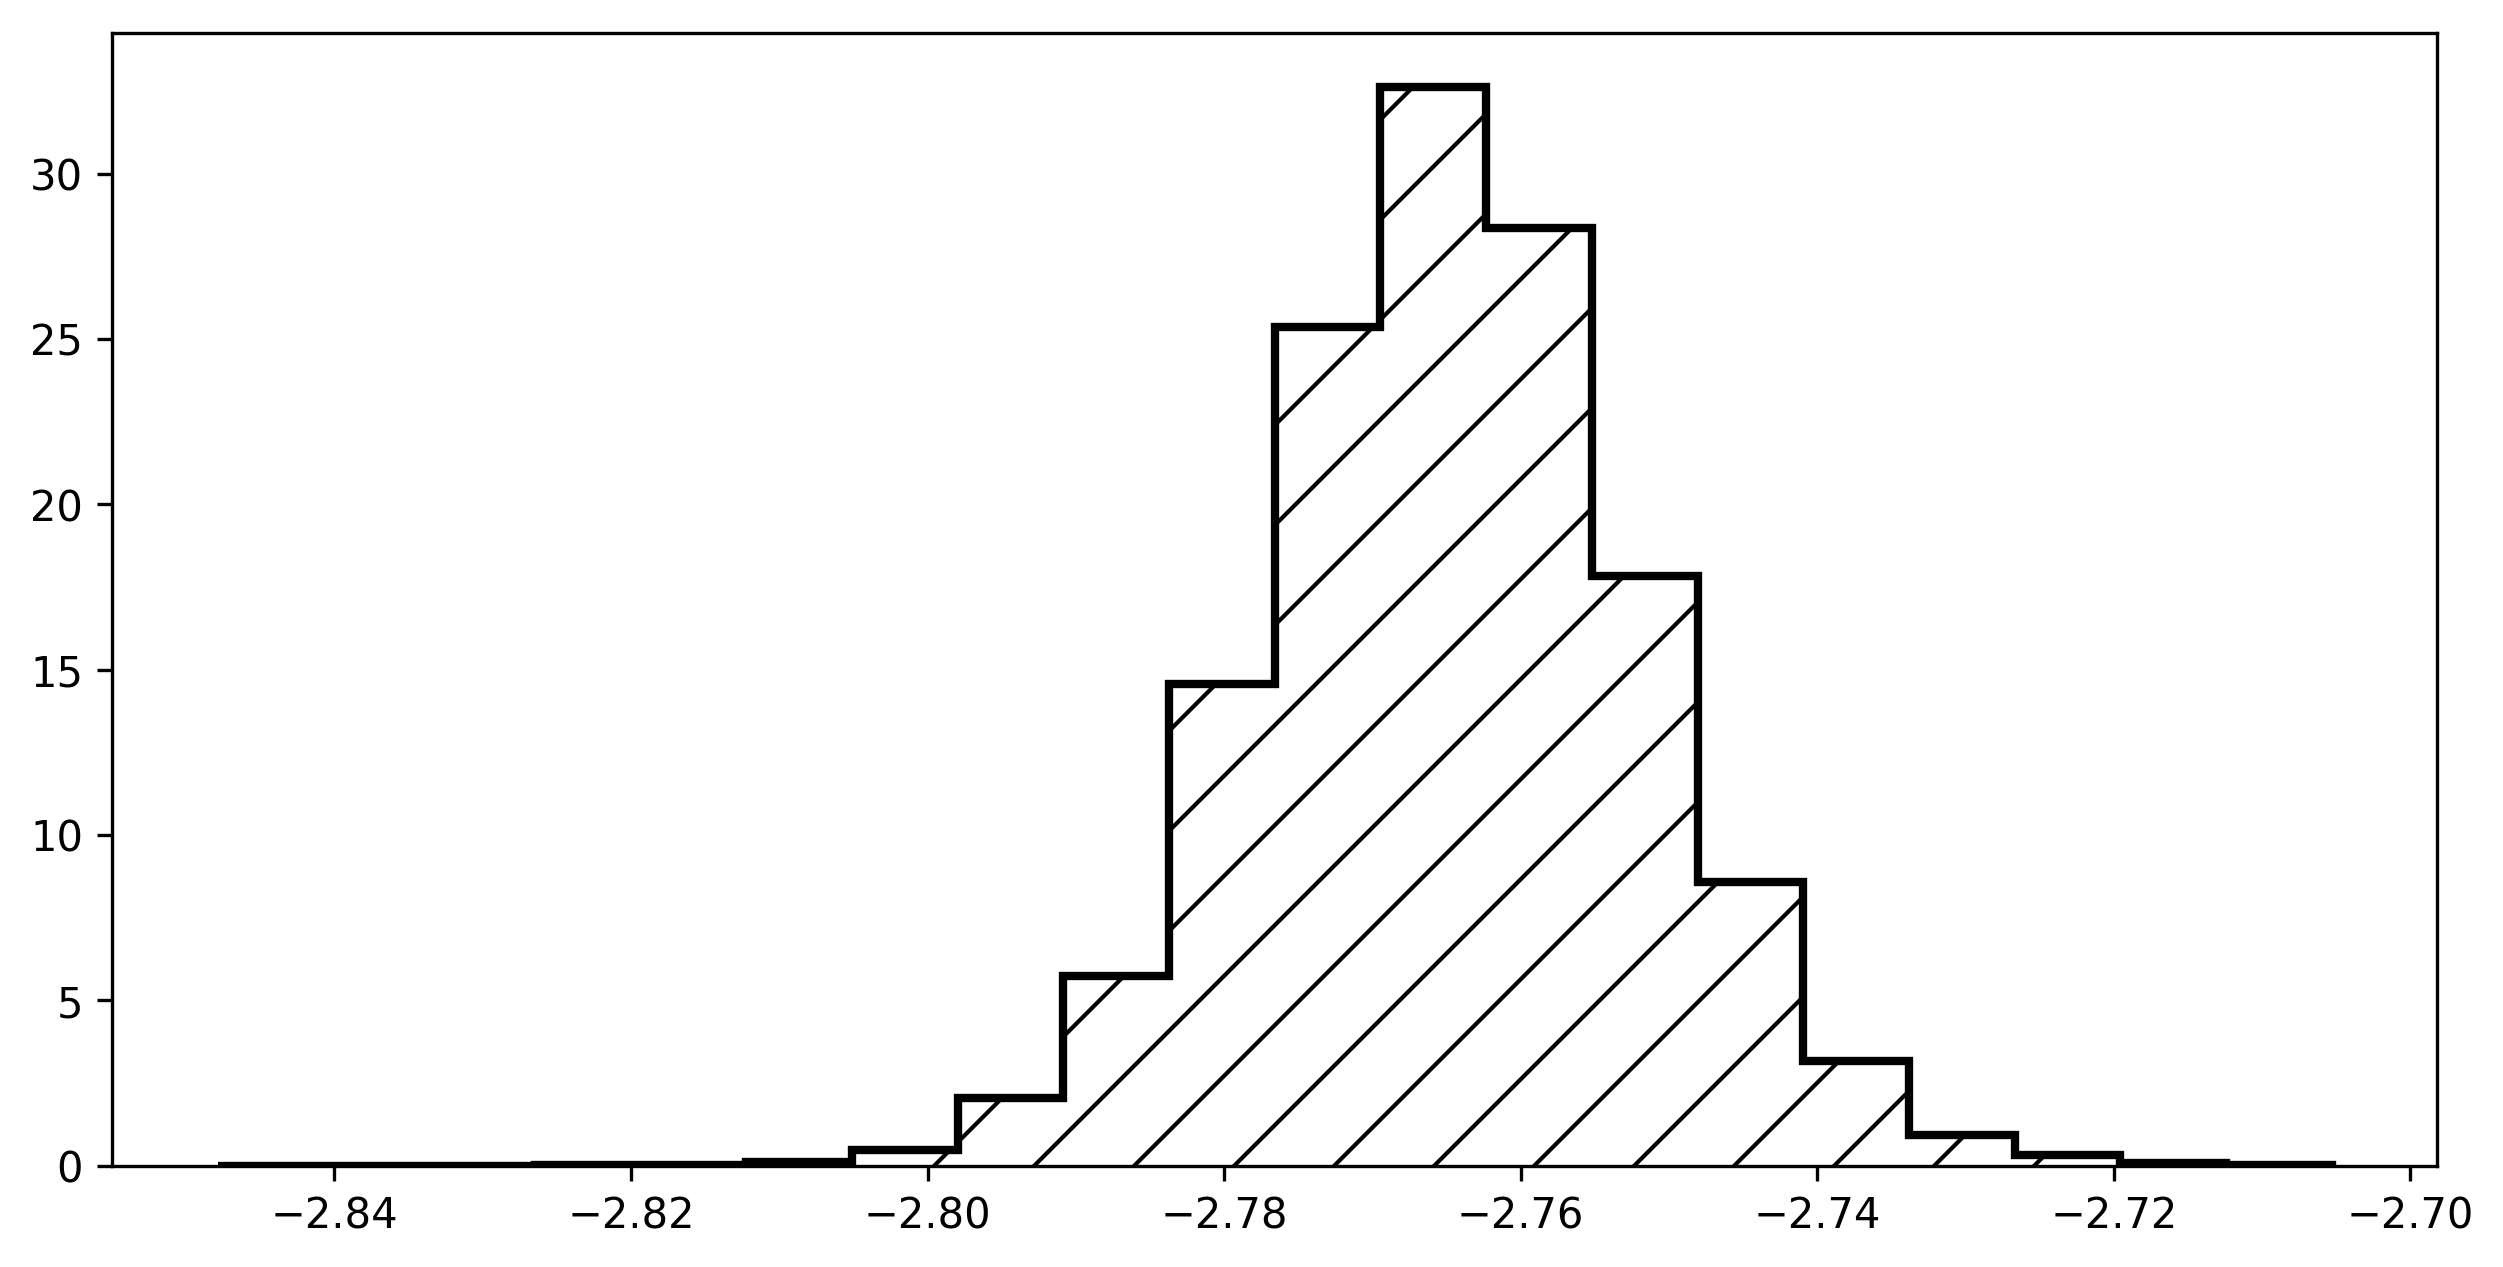

In [24]:
samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
n, bins, patches = pl.hist(samples[:,2], 20, density=True, histtype='step', linewidth=2, facecolor='none', hatch='/', edgecolor='k',fill=True)

In [25]:
num, l2m, stokesQm, stokesUm = read_data(indir, "removed.txt")

stokesQm+=np.random.normal(loc =0.0, scale=noise, size = len(stokesQm))
stokesUm+=np.random.normal(loc =0.0, scale=noise, size = len(stokesUm))

In [26]:
mu_q, cov_q = gp.predict(stokesQ[::-1], l2m[::-1]) #return_cov=False)
std_q = np.sqrt(np.diag(cov_q))

mu_u, cov_u = gp.predict(stokesU[::-1], l2m[::-1]) #return_cov=False)
std_u = np.sqrt(np.diag(cov_u))

diff_qm = (stokesQm[::-1] - mu_q)/noise
diff_um = (stokesUm[::-1] - mu_u)/noise

In [27]:
mu_q, cov_q = gp.predict(stokesQ[::-1], t1) #return_cov=False)
std_q = np.sqrt(np.diag(cov_q))

mu_u, cov_u = gp.predict(stokesU[::-1], t1) #return_cov=False)
std_u = np.sqrt(np.diag(cov_u))

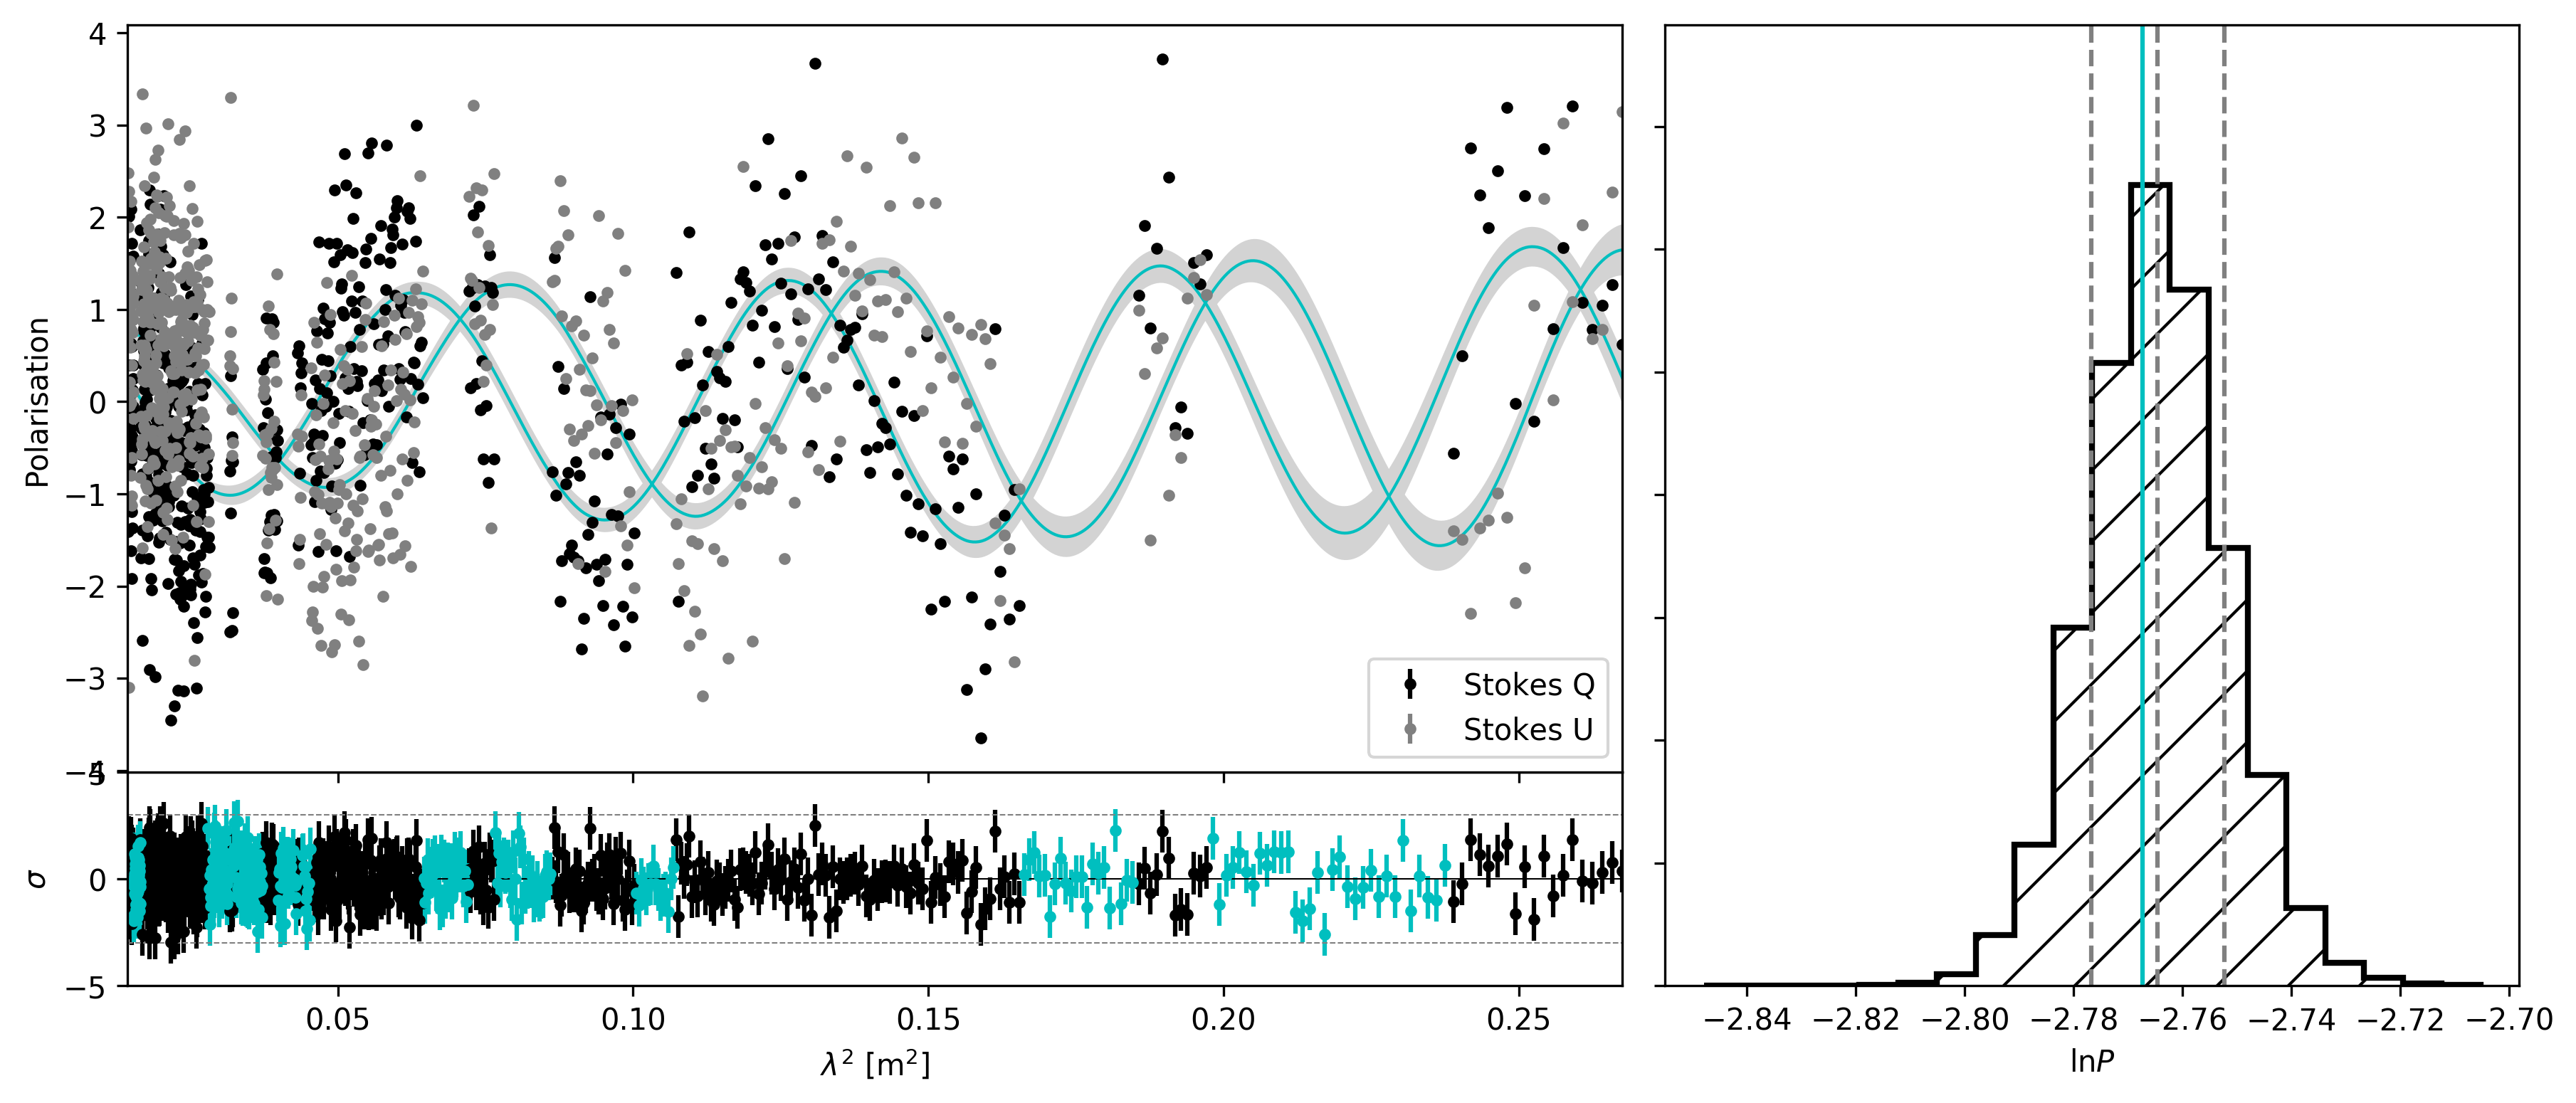

In [28]:
fig = pl.figure()

# ----------

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.2], ylim=(-5, 5), xlim=(np.min(l2),np.max(l2)))

ax1.errorbar(l2[::-1],diff_q, yerr=1.0, fmt='.', c='black', capthick=0)
ax1.errorbar(l2m[::-1],diff_qm, yerr=1.0, fmt='.', c='c', capthick=0)


ax1.plot([np.min(l2),np.max(l2)],[3,3],ls='--',c='grey',lw=0.5)
ax1.plot([np.min(l2),np.max(l2)],[0,0],ls='-',c='black',lw=0.5)
ax1.plot([np.min(l2),np.max(l2)],[-3,-3],ls='--',c='grey',lw=0.5)

ax1.set_ylabel(r"$\sigma$")
ax1.set_xlabel(r"$\lambda^2$ [m$^2$]")



# ----------

ax2 = fig.add_axes([0.1, 0.3, 0.7, 0.7], xticklabels=[], xlim=(np.min(l2),np.max(l2)))

ax2.plot(t1,mu_q, linestyle='-', color = 'c', lw=1.0)
ax2.plot(t1,mu_u, linestyle='-', color = 'c', lw=1.0)

ax2.fill_between(t1,mu_q-std_q,mu_q+std_q, facecolor='lightgray')
ax2.fill_between(t1,mu_u-std_u,mu_u+std_u, facecolor='lightgray')

ax2.errorbar(l2[::-1],stokesQ[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(l2[::-1],stokesU[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")

ax2.legend()

# ----------

peak = 1.2*np.max(n)
ax3 = fig.add_axes([0.82, 0.1, 0.4, 0.9],yticklabels=[],ylim=(0,peak))

n, bins, patches = ax3.hist(samples[:,2], 20, density=True, histtype='step', linewidth=2, facecolor='none', hatch='/', edgecolor='k',fill=True)
p1 = np.percentile(samples[:,2], 16)
ax3.plot([p1,p1],[0,peak],ls='--',c='grey')
p2 = np.percentile(samples[:,2], 50)
ax3.plot([p2,p2],[0,peak],ls='--',c='grey')
p3 = np.percentile(samples[:,2], 84)
ax3.plot([p3,p3],[0,peak],ls='--',c='grey')

p0 = np.log(np.pi/50.)
ax3.plot([p0,p0],[0,peak],ls='-',c='c')
ax3.set_xlabel(r"$\ln P$")
# ----------

pl.show()